# Interactive Urban Flood Predictor

In [1]:
import tensorflow as tf
import numpy as np
import os
from os.path import join
import math

import matplotlib.pylab as plt

# import ipywidgets (interaction library)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import norm

# import neural net code
import nn
import nn_model
import load_data

## 1. The CNN Model

In [2]:
# files
rain_file = "data/744/rain_pattern_str.txt"
dem_file = "data/744/dem/744_dem_asc.asc.gz"
waterdepth_path = "data/744/waterdepth"

model_path = "model"
model_name = "zurich-744_512_01"

256x256 model

In [ ]:
# parameters
patch_size = 256
input_channel = 6 # dem + mask + slope + cos + sin + curvature
output_channel = 1 # water level
vector_length = 12

lin_size = [4096] # 4096 = 32 * 32 * 4
reshape_size = [32,32,4] # reshape_size is determined by patch_size / pooling_size / .. / pooling_size, which is 32

net_channel = [32,64,128]
kernel_size = [[3,3],[3,3],[3,3]]
pooling_size = [[2,2],[2,2],[2,2]] # size of the latent layer: patch_size / pooling_size / .. / pooling_size = 32

# the cnn model used for training and testing
initializer = tf.contrib.layers.xavier_initializer()
af = tf.nn.leaky_relu
phs, ls, vs = nn_model.prediction_network_new([patch_size, patch_size, input_channel],vector_length, lin_size, reshape_size, net_channel, output_channel, kernel_size, pooling_size, initializer, af)

512x512 model

In [3]:
# parameters
patch_size = 512
input_channel = 6 # dem + mask + slope + cos + sin + curvature
output_channel = 1 # water level
vector_length = 12

lin_size = [4096] # 4096 = 32 * 32 * 4
reshape_size = [32,32,4] # reshape_size is determined by patch_size / pooling_size / .. / pooling_size, which is 32

net_channel = [32,64,128,128]
kernel_size = [[3,3],[3,3],[3,3],[3,3]]
pooling_size = [[2,2],[2,2],[2,2],[2,2]] # size of the latent layer: patch_size / pooling_size / .. / pooling_size = 32

# the cnn model used for training and testing
initializer = tf.contrib.layers.xavier_initializer()
af = tf.nn.leaky_relu
phs, ls, vs = nn_model.prediction_network_new([patch_size, patch_size, input_channel],vector_length, lin_size, reshape_size, net_channel, output_channel, kernel_size, pooling_size, initializer, af)

Tensor("encode-0:0", shape=(?, 256, 256, 32), dtype=float32)
Tensor("encode-1:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("encode-2:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("encode-3:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("l-0:0", shape=(?, 4096), dtype=float32)
Tensor("concat:0", shape=(?, 32, 32, 132), dtype=float32)
Tensor("decode-3:0", shape=(?, 64, 64, 32), dtype=float32)
Tensor("decode-2:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("decode-1:0", shape=(?, 256, 256, 128), dtype=float32)
Tensor("decode-0:0", shape=(?, 512, 512, 1), dtype=float32)


## 2.  Load Data

### 2.1 Restore CNN Model

In [4]:
model_id = "/-79"

sess=tf.Session()
tf.global_variables_initializer().run(session=sess)
saver = tf.train.Saver()
saver.restore(sess,join(model_path,model_name+model_id))

INFO:tensorflow:Restoring parameters from model\zurich-744_512_01/-79


### 2.2 Load DEM Data

In [5]:
dem_array = load_data.load_dem(dem_file)
mask_indice = dem_array<0
dem_array = load_data.generate_features(dem_array)

loading data_zurich/744/dem/744_dem_asc.asc.gz
(6175, 6050)
generating features


### 2.3 Load Rainfall Data

In [6]:
rainfall_name, rainfall_intensity = load_data.rainfall_pattern(rain_file)

## 3. Make Predictions

### 3.1 Functions

In [7]:
def make_prediction(dem_array, rain_pattern_vector, batch_size=32, random_patches=False):
    '''
    calculate the mean value of randomly positioned prediction patches and return the result as the final prediction
    
    this method is computationally heavier but produce more stable result
    '''
    height, width, _ = dem_array.shape
    
    # necessary data for prediction
    max_x = np.zeros((height,width), dtype=np.float32)
    sum_x = np.zeros((height,width), dtype=np.float32)
    sum_x2 = np.zeros((height,width), dtype=np.float32)
    n_x = np.zeros((height,width), dtype=np.float32)
    stddev = np.zeros((height,width), dtype=np.float32)
    
    # generate patch locations
    patches=[]
    num_patches = 0
    if random_patches:
        num_patches = max(batch_size, 3 * math.ceil((height*width)/(patch_size**2)))
        
        i=0
        while i < num_patches:
            w = np.random.randint(width - patch_size)
            h = np.random.randint(height - patch_size)

            if not np.any(dem_array[h:h+patch_size,w:w+patch_size,0]):
                continue

            i+=1

            patches.append([h,w])
    else:
        # generate patch locations
        patches = [[min(h,height-patch_size-1),min(w,width - patch_size-1)] for h in range(0, height-patch_size,patch_size) for w in range(0, width - patch_size, patch_size)]
        # select those that contains catchment areas
        patches = [[h, w] for h, w in patches if np.any(dem_array[h:h+patch_size,w:w+patch_size,0])]
        num_patches = len(patches)
        
    patches = np.array(patches,dtype=np.uint32)
    
    print("testing")

    for i in range(0, num_patches, batch_size):
        start = i
        end = min(i+batch_size, num_patches-1)
        print(start,end,num_patches)

        x1 = np.array([dem_array[patches[j,0]:patches[j,0]+patch_size,patches[j,1]:patches[j,1]+patch_size] for j in range(start,end)])
        x2 = np.array([rain_pattern_vector for _ in range(end-start)])

        result = sess.run(ls["prediction"], feed_dict={phs["x1"]:x1,phs["x2"]:x2})

        for j in range(end-start):
            h,w = patches[start + j]

            max_x[h:h+patch_size,w:w+patch_size] = np.maximum(max_x[h:h+patch_size,w:w+patch_size],result[j])
            sum_x[h:h+patch_size,w:w+patch_size] += result[j]
            sum_x2[h:h+patch_size,w:w+patch_size] += np.square(result[j])
            n_x[h:h+patch_size,w:w+patch_size] += 1
    
    mean_x = np.copy(sum_x)
    mean_x[n_x>0] /= n_x[n_x>0]
    
    mask_indice_inv = n_x > 0
    stddev[mask_indice_inv] = np.sqrt(sum_x2[mask_indice_inv]/n_x[mask_indice_inv] - np.square(sum_x[mask_indice_inv]/n_x[mask_indice_inv]))
    
    return mean_x, stddev

In [11]:
def render_prediction(mask_indice, output, rain_pattern_vector, target_array=None, img_height = 20):
    height, width = output.shape
    
    output[mask_indice]=np.nan
    
    if target_array is None:    
        plt.figure(figsize=(2 * math.ceil(width / height * img_height),img_height))
        plt.subplot(1,2,1)
        plt.gca().set_title("rainfall pattern")
        plt.plot(rain_pattern_vector)
        
        plt.subplot(1,2,2)
        plt.gca().set_title("prediction")
        plt.imshow(output, cmap=plt.cm.terrain,vmin=0,vmax=5)

    else:
        target_array[mask_indice]=np.nan
        
        plt.figure(figsize=(2 * math.ceil(width / height * img_height),2 * img_height))
        plt.subplot(2,2,1)
        plt.gca().set_title("prediction")
        plt.imshow(output, cmap=plt.cm.terrain,vmin=0,vmax=5)
        
        plt.subplot(2,2,2)
        plt.gca().set_title("target")
        plt.imshow(target_array, cmap=plt.cm.terrain,vmin=0,vmax=5)
        
        plt.subplot(2,2,3)
        plt.gca().set_title("rainfall pattern")
        plt.plot(rain_pattern_vector)
        
        plt.subplot(2,2,4)
        plt.gca().set_title("error [-1, 1]")
        plt.imshow(target_array - output, cmap=plt.cm.seismic,vmin=-1,vmax=1)
    plt.show()

### 3.2 On Generated Rain Pattern

In [12]:
def generate_rain_pattern(mu,sigma,minval,maxval):
    n=nn_model.PATTERN_RESOLUTION
    pattern=norm.pdf(np.arange(n)/(n-1) * 10,mu,sigma)
    pattern/=np.max(pattern)
    pattern*=(maxval-minval)
    pattern+=minval
    
    mean_x, _ = make_prediction(dem_array, pattern)
    render_prediction(mask_indice, mean_x, pattern)

testing
0 32 70
32 64 70
64 69 70


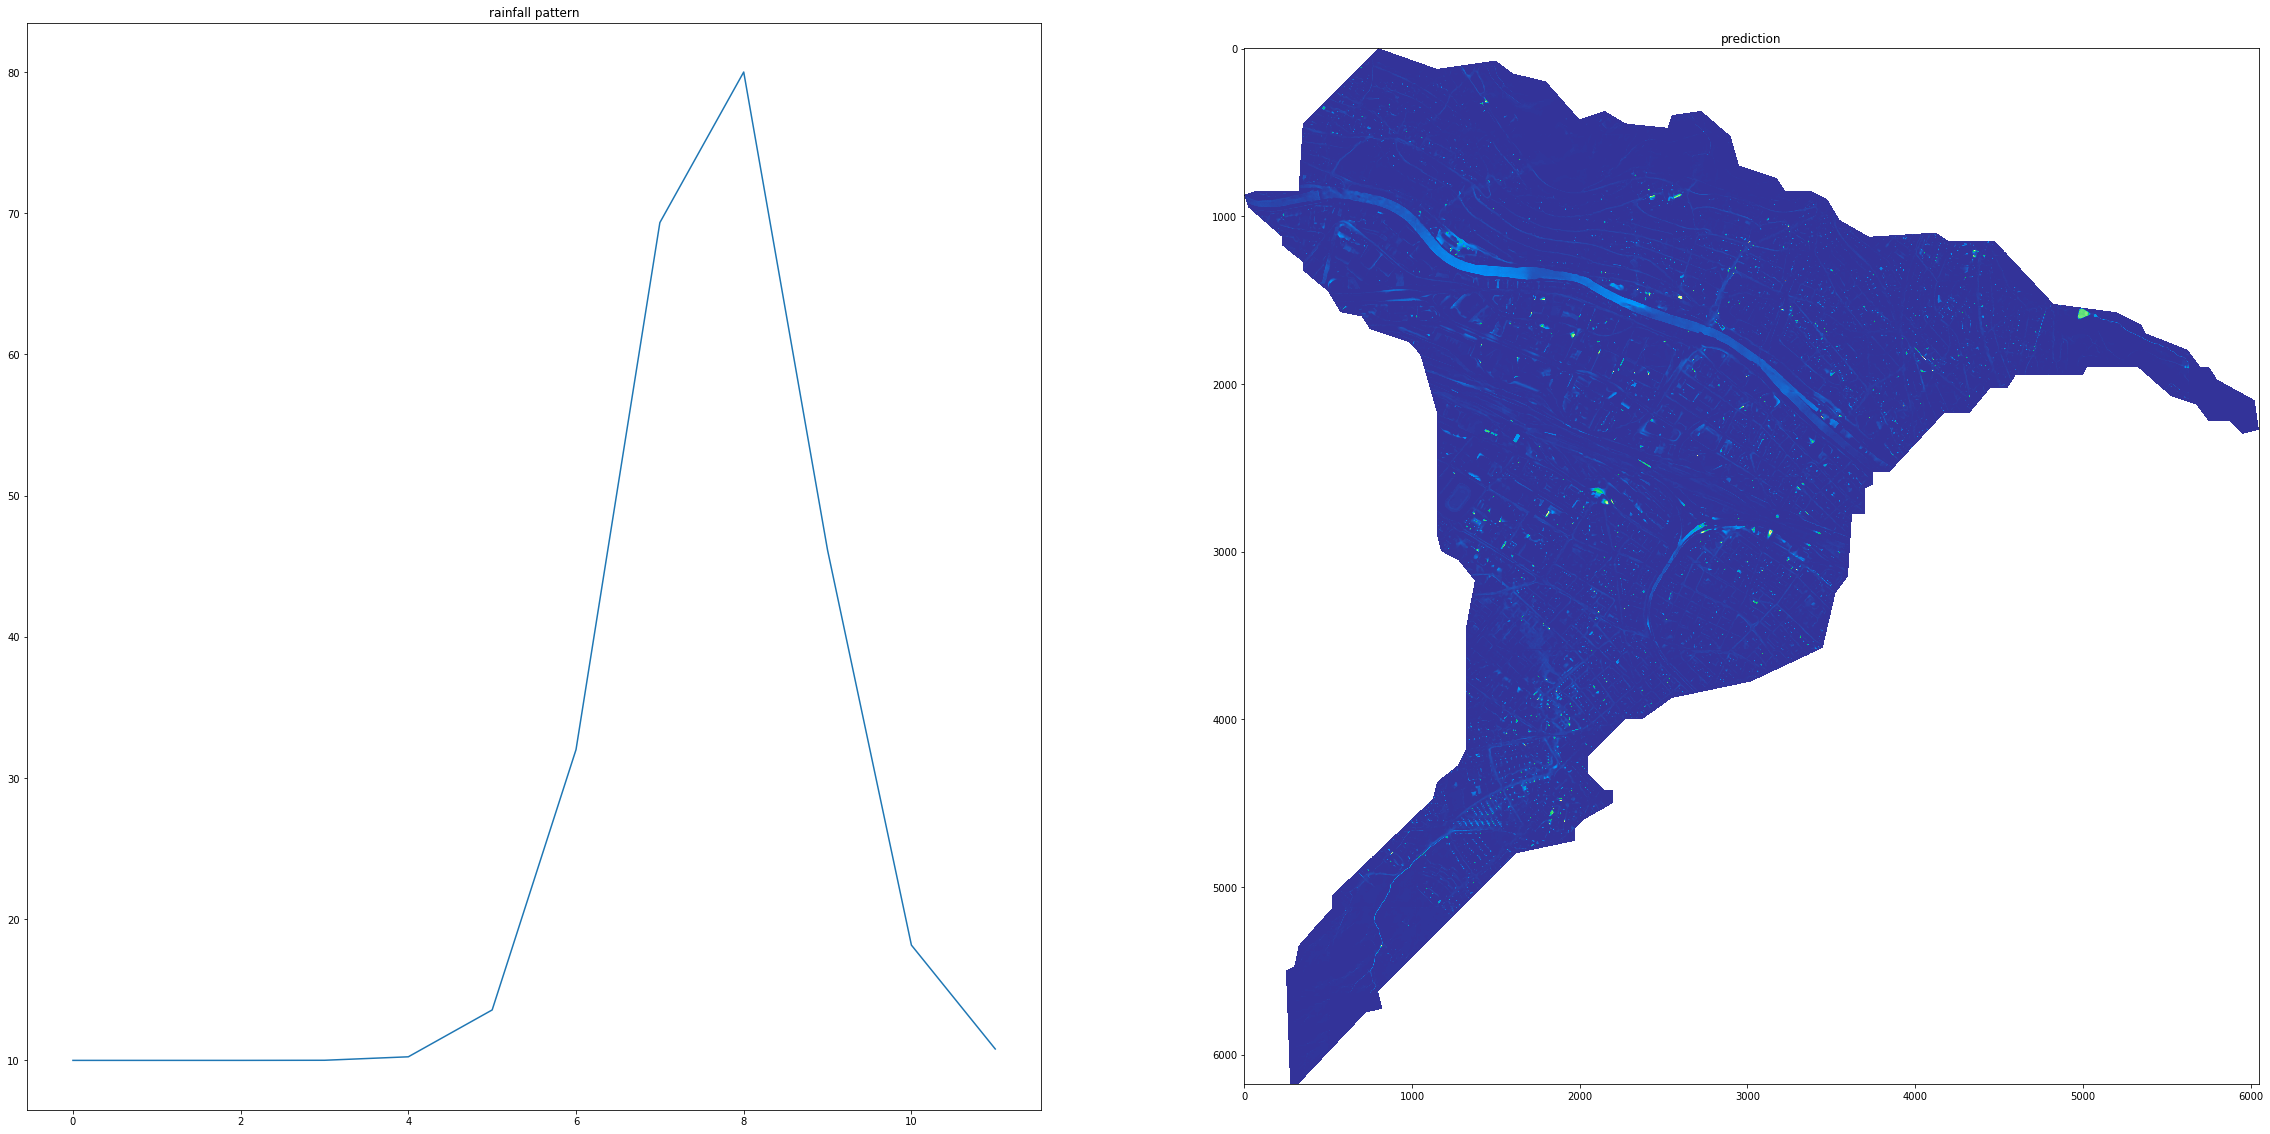

In [13]:
generate_rain_pattern(7,1,10,80)

interactive version

In [14]:
interact(generate_rain_pattern,mu=widgets.FloatSlider(min=0,max=nn_model.PATTERN_RESOLUTION,step=0.5,value=nn_model.PATTERN_RESOLUTION/2),sigma=widgets.FloatSlider(min=0.1,max=2,step=0.1,value=0.1),minval=widgets.IntSlider(min=0,max=40,step=10,value=20),maxval=widgets.IntSlider(min=80,max=160,step=10,value=80))

interactive(children=(FloatSlider(value=6.0, description='mu', max=12.0, step=0.5), FloatSlider(value=0.1, des…

<function __main__.generate_rain_pattern>

### 3.3 On Testset

In [15]:
random_seed = 1 # random seed used for training the model

np.random.seed(random_seed)

rainfall_index = np.array([k for k in rainfall_name.keys()],dtype=np.int32)

np.random.shuffle(rainfall_index)
test_pattern_index = rainfall_index[:len(rainfall_index)//3] # 6
test_pattern_name = [rainfall_name[i] for i in test_pattern_index]

print(test_pattern_index, test_pattern_name)
# for zurich-744 512x512, it should be [ 6  3 13  2 14  7] ['tr2-2', 'tr20', 'tr5-3', 'tr10', 'tr10-3', 'tr5-2']

[ 6  3 13  2 14  7] ['tr2-2', 'tr20', 'tr5-3', 'tr10', 'tr10-3', 'tr5-2']


In [18]:
def test_rain_pattern(pattern_index):
    pattern=rainfall_intensity[pattern_index]
    target_array = load_data.load_waterdepth(waterdepth_path, [rainfall_name[pattern_index]])
    
    mean_x, _ = make_prediction(dem_array, pattern)
    render_prediction(mask_indice, mean_x, pattern, target_array = target_array)

loading 744_tr20_WDraster_PEAK.asc.gz
(6175, 6050)
testing
0 32 70
32 64 70
64 69 70


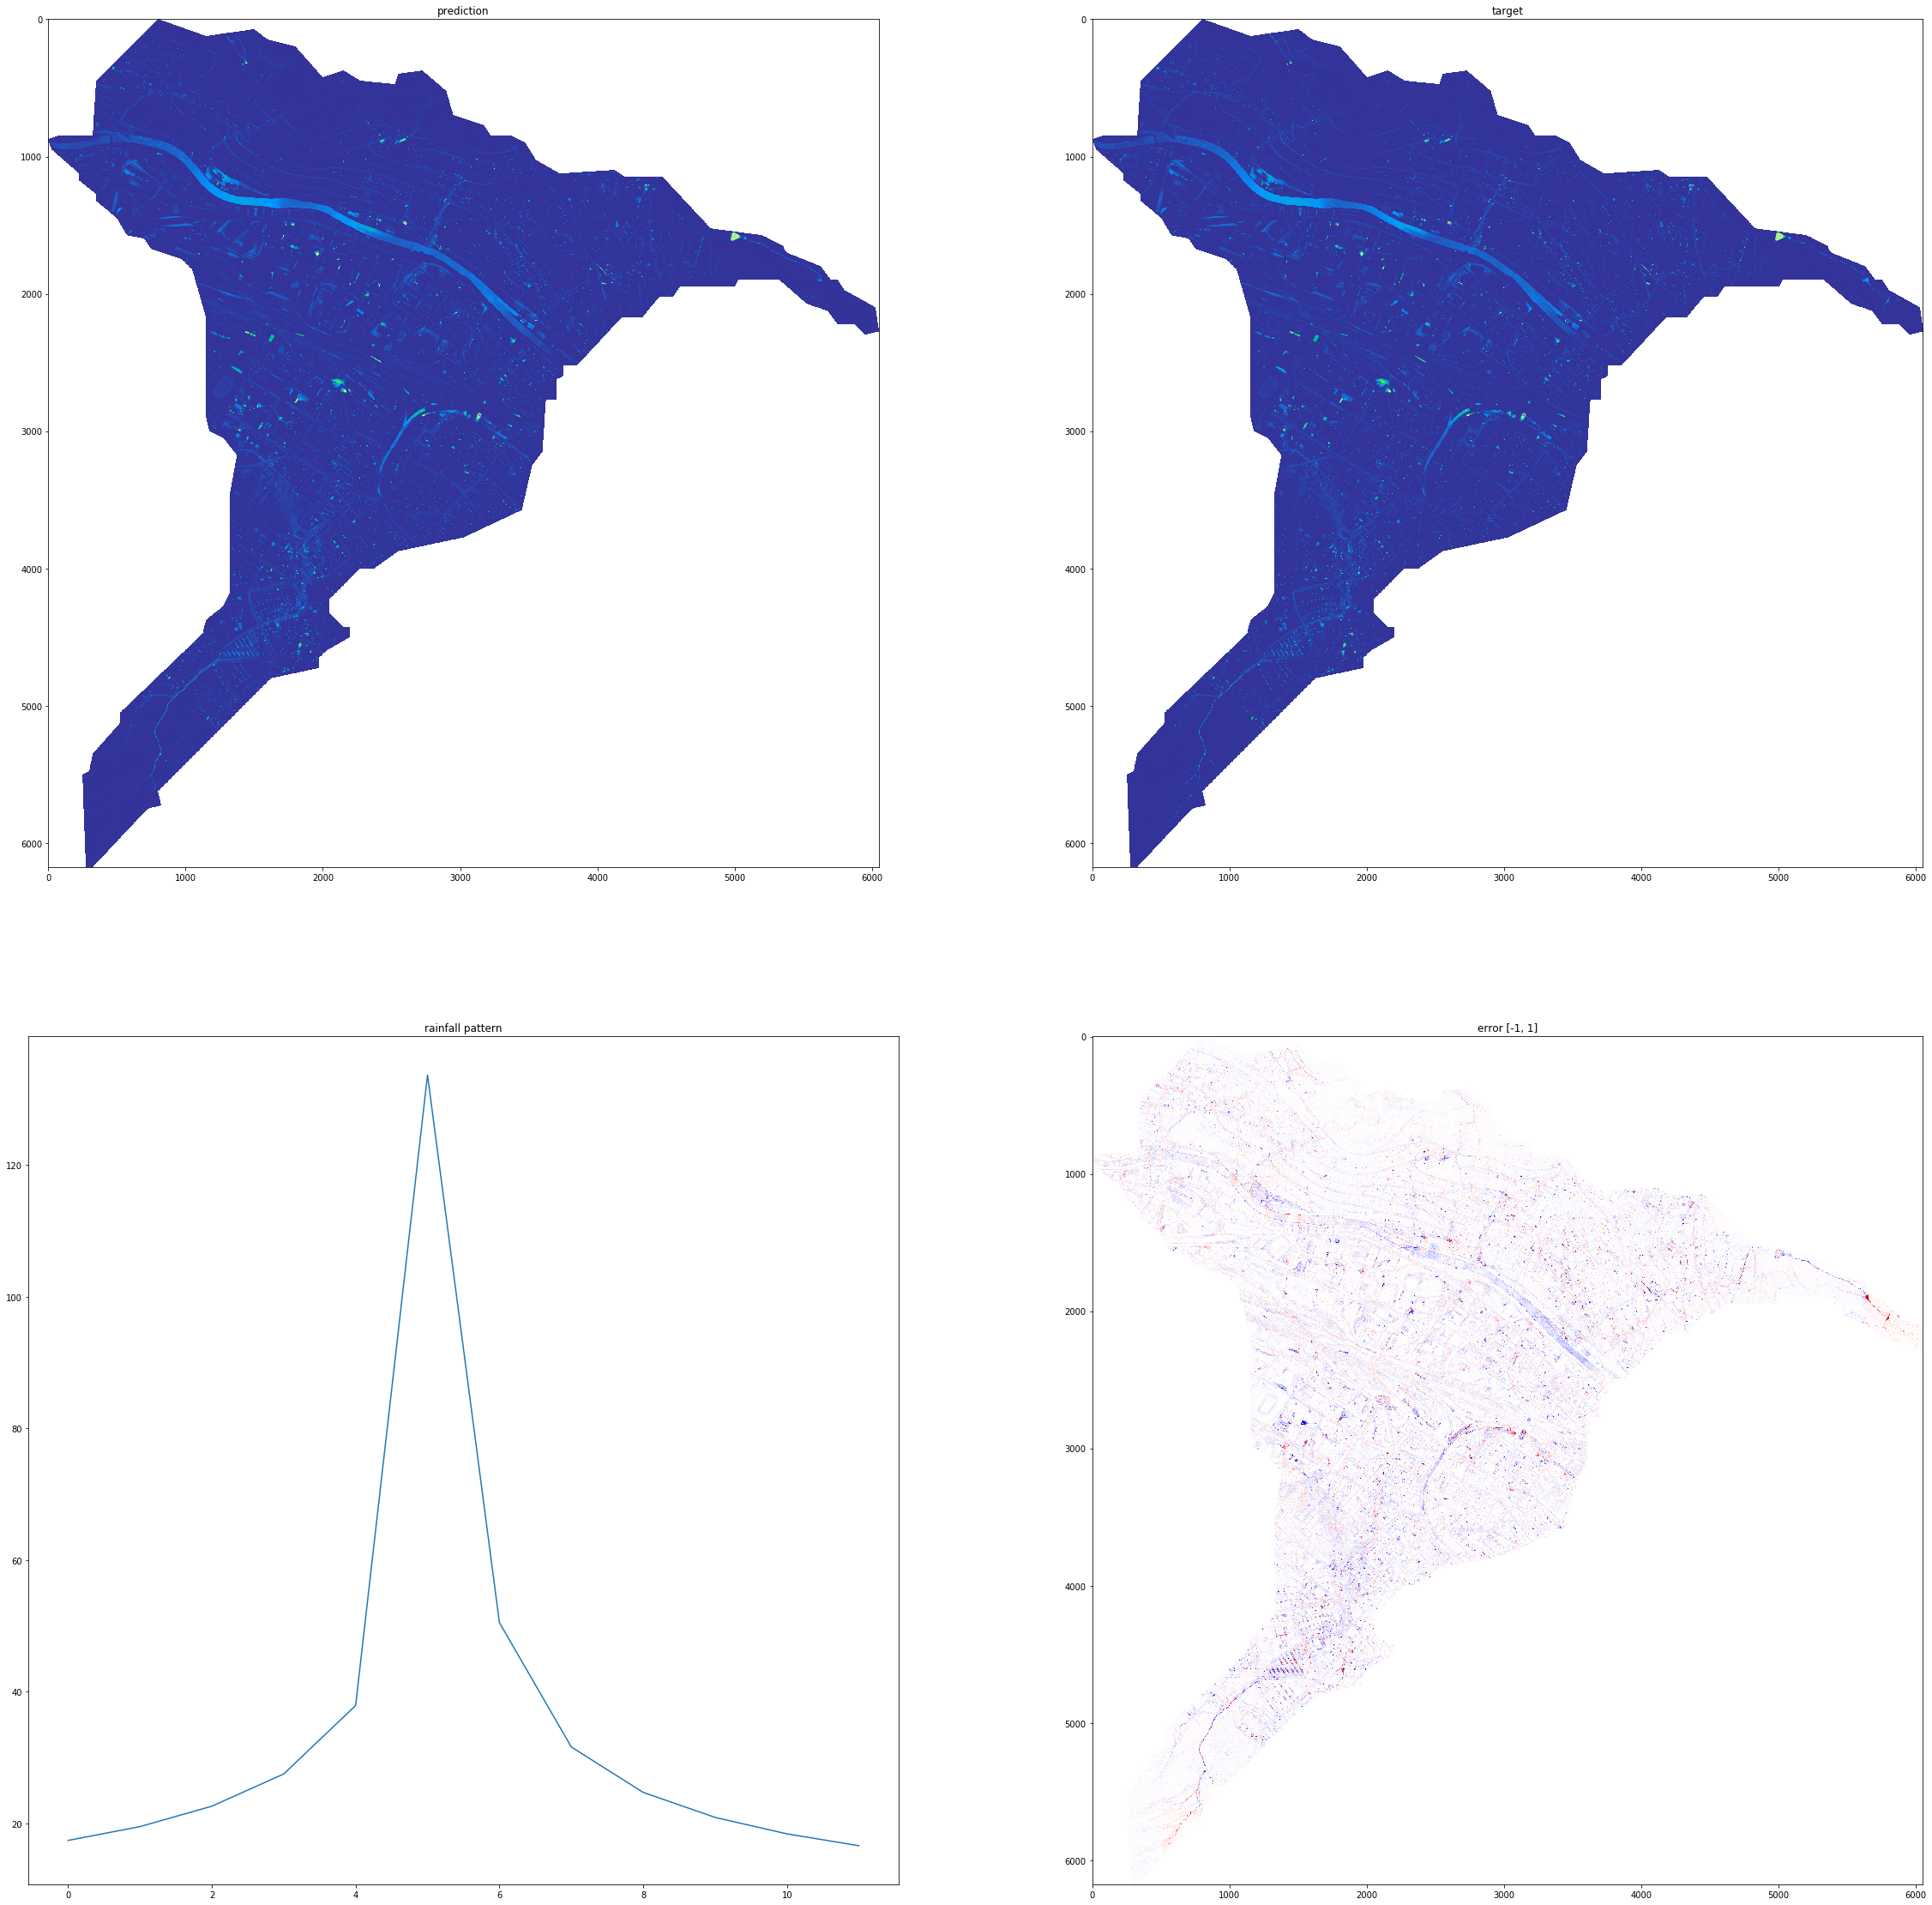

In [19]:
test_rain_pattern(3)

In [20]:
interact(test_rain_pattern,pattern_index=[[test_pattern_name[i],test_pattern_index[i]] for i in range(len(test_pattern_index))])

interactive(children=(Dropdown(description='pattern_index', options=(['tr2-2', 6], ['tr20', 3], ['tr5-3', 13],…

<function __main__.test_rain_pattern>